### Step 1 – Load Data

In [48]:
import os

print("Current working directory:", os.getcwd())

Current working directory: /Users/babak/Github/ml-projects/01_airbnb_price_regression/notebooks


In [49]:
# Manually set the working directory to your notebook location
target_dir = "/Users/babak/Github/ml-projects/01_airbnb_price_regression/notebooks"
os.chdir(target_dir)

print("Now working in:", os.getcwd())

Now working in: /Users/babak/Github/ml-projects/01_airbnb_price_regression/notebooks


In [60]:
import pandas as pd

pd.set_option('future.no_silent_downcasting', True)

df = pd.read_csv('../data/processed/featured_listings.csv')
print(f"Loaded data with shape: {df.shape}")
df.head()

Loaded data with shape: (5596, 23)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,price_log,days_since_last_review,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,13188,Garden level studio in ideal loc.,51466,Emma,NaN,Riley Park,49.247730,-123.105090,Entire home/apt,136.0,...,1.89,1,109,56,Municipal registration number: 25-156058<br />...,4.919981,66.0,False,False,False
1,13358,Downtown Designer suite,52116,Lynn,NaN,Downtown,49.281174,-123.125931,Entire home/apt,225.0,...,3.11,1,135,50,Municipal registration number: 25-157257,5.420535,66.0,False,False,False
2,16254,Close to PNE/Hastings Park Garden level suite,63238,Jason,NaN,Hastings-Sunrise,49.277210,-123.040860,Entire home/apt,680.0,...,0.09,1,249,0,NaN,6.523562,1075.0,False,False,False
3,16611,"1 block to skytrain station, shops,restaurant,...",58512,Q,NaN,Grandview-Woodland,49.263390,-123.071450,Entire home/apt,NaN,...,0.03,5,89,0,NaN,NaN,2700.0,False,False,False
4,17765,"Central location, nice little apartment",68672,James,NaN,Mount Pleasant,49.261320,-123.108450,Entire home/apt,NaN,...,1.32,1,0,0,Municipal registration number: 21-156705,NaN,1377.0,False,False,False


### Step 2 – Define Target + Features

In [69]:
# Drop rows where price is missing
df = df.dropna(subset=['price'])

# Drop 'price_log' if exists (to avoid data leakage)
if 'price_log' in df.columns:
    df = df.drop(columns=['price_log'])
    print("Dropped 'price_log' to avoid data leakage.")

# Drop unnecessary or ID columns
drop_cols = ['id', 'name', 'host_id', 'host_name', 'last_review', 'license']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Separate target and features
target = 'price'
y = df[target]
X = df.drop(columns=[target])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Ensure index alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Print confirmation
print("Features and target prepared.")
print("X shape:", X.shape)
print("Remaining dtypes:\n", X.dtypes.value_counts())


Dropped 'price_log' to avoid data leakage.
Features and target prepared.
X shape: (4584, 38)
Remaining dtypes:
 bool       28
float64     5
int64       5
Name: count, dtype: int64


### Step 3 – Train/Test Split

In [70]:
from sklearn.model_selection import train_test_split

# STEP 3: Train-test split (using already cleaned and encoded X, y from Step 2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Training rows: {X_train.shape[0]} | Test rows: {X_test.shape[0]}")


Training rows: 3667 | Test rows: 917


### Step 4 – Baseline Model

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Predict the mean of y_train
mean_price = y_train.mean()
y_pred_baseline = pd.Series([mean_price] * len(y_test), index=y_test.index)

# Check for missing values in y_test or predictions
print("Missing values in y_test:", y_test.isnull().sum())
print("Missing values in y_pred_baseline:", y_pred_baseline.isnull().sum())

# Apply mask safely
mask = ~y_test.isnull()
mae = mean_absolute_error(y_test[mask], y_pred_baseline[mask])
rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred_baseline[mask]))

# Show metrics
print(f"Baseline Mean Prediction: {mean_price:.2f}")
print(f"Baseline MAE: {mae:.2f}")
print(f"Baseline RMSE: {rmse:.2f}")


Missing values in y_test: 0
Missing values in y_pred_baseline: 0
Baseline Mean Prediction: 227.33
Baseline MAE: 147.56
Baseline RMSE: 710.55


In [ ]:
# Check for data leakage before model training because of potential leakage columns (price, price_log, etc.)
print("Potential leakage columns:", [col for col in X_train.columns if 'price' in col.lower()])

Potential leakage columns: []


### Step 5 – Linear Regression

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. One-hot encode train and test
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# 2. Drop duplicate columns (edge case protection)
X_train_encoded = X_train_encoded.T.drop_duplicates().T
X_test_encoded = X_test_encoded.T.drop_duplicates().T

# 3. Align test columns to match training columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 4. Fill missing values and handle types
X_train_encoded = X_train_encoded.fillna(0).infer_objects(copy=False)
X_test_encoded = X_test_encoded.fillna(0).infer_objects(copy=False)

# 5. Train model
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# 6. Predict
y_pred_lr = lr_model.predict(X_test_encoded)

# 7. Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression MAE: {mae_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")


Linear Regression MAE: 140.00
Linear Regression RMSE: 699.56


### Step 6 – Ridge & Random Forest Regression

In [74]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Set seed for reproducibility
SEED = 42

# Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=SEED)
ridge_model.fit(X_train_encoded, y_train)
y_pred_ridge = ridge_model.predict(X_test_encoded)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print("Ridge Regression")
print(f"MAE: {mae_ridge:.2f}")
print(f"RMSE: {rmse_ridge:.2f}")

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=SEED)
rf_model.fit(X_train_encoded, y_train)
y_pred_rf = rf_model.predict(X_test_encoded)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\nRandom Forest Regressor")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")


Ridge Regression
MAE: 139.82
RMSE: 700.50

Random Forest Regressor
MAE: 120.35
RMSE: 622.89


### Step 7 – Model Comparison (Compare All Models)

Model Performance Comparison:
               Model         MAE        RMSE
0      Random Forest  120.354650  622.888799
1  Linear Regression  140.002187  699.559094
2   Ridge Regression  139.815533  700.496610
3    Baseline (Mean)  147.555520  710.547599


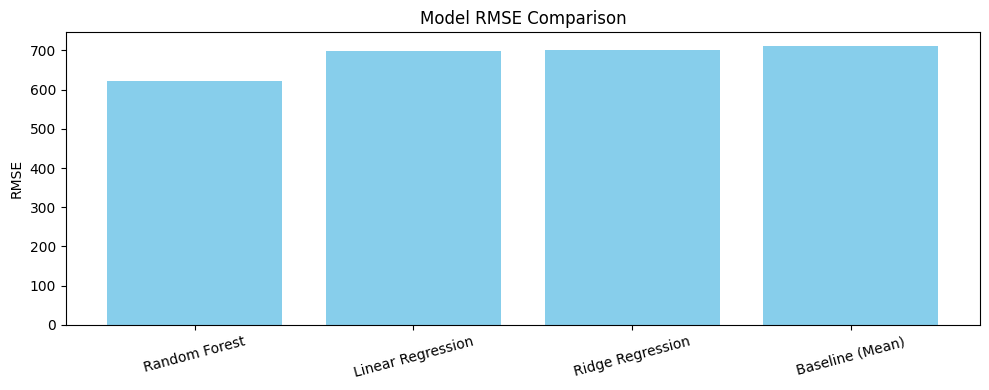

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison table
results = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'Linear Regression', 'Ridge Regression', 'Random Forest'],
    'MAE': [mae, mae_lr, mae_ridge, mae_rf],
    'RMSE': [rmse, rmse_lr, rmse_ridge, rmse_rf]
})

# Sort by RMSE (lower is better)
results = results.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("Model Performance Comparison:")
print(results)

# Optional: Bar chart visualization
plt.figure(figsize=(10, 4))
plt.bar(results['Model'], results['RMSE'], color='skyblue')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
